In [24]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [25]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("Resources/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [26]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

Text(0, 0.5, 'Settle(Yen)')

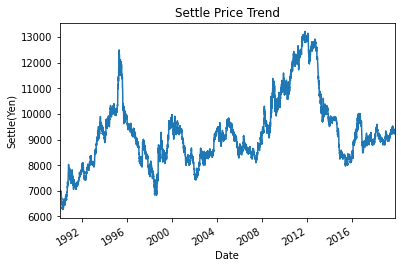

In [27]:
# Plot just the "Settle" column from the dataframe:
yen_futures["Settle"].plot(title="Settle Price Trend")
plt.ylabel("Settle(Yen)")

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

Text(0, 0.5, 'Settle (Yen)')

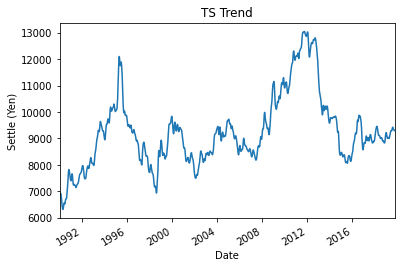

In [28]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:

ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])
ts_trend.plot(title= "TS Trend")
plt.ylabel("Settle (Yen)")

<AxesSubplot:title={'center':'TS Noise'}, xlabel='Date'>

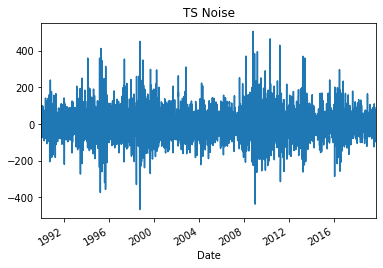

In [29]:
ts_noise.plot(title = "TS Noise")

In [30]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:

yen_settle = pd.DataFrame(yen_futures["Settle"])
yen_settle["Trend"] = ts_trend
yen_settle["Noise"] = ts_noise

yen_settle.head()

,Settle,Trend,Noise
Date,,,
1990-01-02,6847.0,6908.503967,-61.503967
1990-01-03,6887.0,6908.799756,-21.799756
1990-01-04,7008.0,6909.057104,98.942896
1990-01-05,6950.0,6909.223948,40.776052
1990-01-08,6959.0,6909.310062,49.689938


Text(0, 0.5, 'Settle, Trend (Y)')

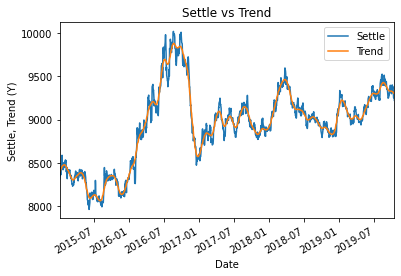

In [31]:
# Plot the Settle Price vs. the Trend for 2015 to the present

yen_settle[["Settle","Trend"]].loc["2015":].plot(title = "Settle vs Trend")

plt.ylabel("Settle, Trend (Y)")

Text(0, 0.5, 'Settle, Noise (Yen)')

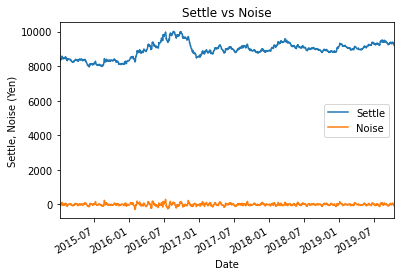

In [32]:
# Plot the Settle Noise

yen_settle[["Settle","Noise"]].loc["2015":].plot(title = "Settle vs Noise")

plt.ylabel("Settle, Noise (Yen)")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [36]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s

returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [37]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))

model = ARMA(returns.values, order=(2,1))


# Fit the model and assign it to a variable called results

results = model.fit()

In [40]:
# Output model summary results:

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sun, 15 Nov 2020   AIC                          15798.142
Time:                        18:36:08   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3064      1.277     -0.240      0.810      -2.809       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2948      1.277      0.231      0.817      -2.208       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3328           +0.0000j            3.3328            0.5000
AR.2         -157.1207           +0.0000j          157.1207            0.5000
MA.1           -3.3916           +0.0000j            3.3916            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
# p values of the lags are above our treshold of 0.05, thus our ARMA model is not a good fit to make predictions for this data.

Text(0, 0.5, 'Return (%)')

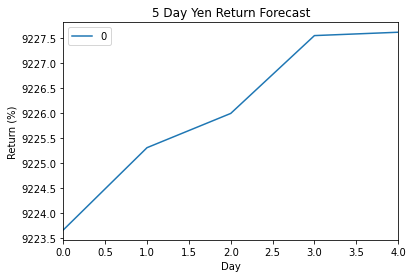

In [70]:
# Plot the 5 Day Returns Forecast

pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Yen Return Forecast")
plt.xlabel("Day")
plt.ylabel("Return (%)")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [68]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))

model = ARIMA(yen_settle["Settle"], order=(5, 1, 2))

# Fit the model

results = model.fit()

/Users/draganbogatic/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/draganbogatic/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [69]:
# Output model summary results:

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -41944.316
Method:                       css-mle   S.D. of innovations             64.278
Date:                Sun, 15 Nov 2020   AIC                          83906.632
Time:                        18:51:42   BIC                          83968.953
Sample:                             1   HQIC                         83928.031
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3160      0.701      0.451      0.652      -1.057       1.689
ar.L1.D.Settle    -0.2559      0.502     -0.510      0.610      -1.240       0.728
ar.L2.D.Settle     0.2976      0.296      1.005      0.315      -0.283       0.878
ar.L3.D.Settle    -0.0102      0.014     -0.747      0.455      -0.037       0.016
ar.L4.D.Settle    -0.0219      0.015     -1.492      0.136      -0.051       0.007
ar.L5.D.Settle    -0.0003      0.017     -0.016      0.987      -0.034       0.033
ma.L1.D.Settle     0.2410      0.502      0.480      0.631      -0.743       1.225
ma.L2.D.Settle    -0.3050      0.291     -1.047      0.295      -0.876       0.266
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5227           -0.0000j            1.5227           -0.5000
AR.2            2.4630           -1.1785j            2.7304           -0.0710
AR.3            2.4630           +1.1785j            2.7304            0.0710
AR.4           -4.0499           -0.0000j            4.0499           -0.5000
AR.5          -76.8806           -0.0000j           76.8806           -0.5000
MA.1           -1.4582           +0.0000j            1.4582            0.5000
MA.2            2.2483           +0.0000j            2.2483            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
# p values of the lags are above our treshold of 0.05, thus our ARIMA model is not a good fit to make predictions for this data.

Text(0.5, 0, 'Day)')

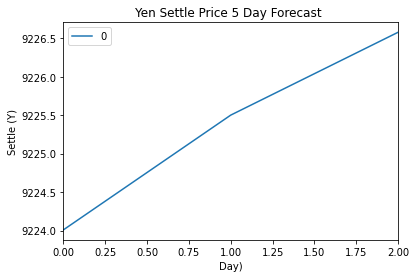

In [57]:
# Plot the 5 Day Price Forecast

pd.DataFrame(results.forecast(steps=3)[0]).plot(title="Yen Settle Price 5 Day Forecast ")
plt.ylabel("Settle (Y)")
plt.xlabel("Day)")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [72]:
import arch 
from arch import arch_model

In [76]:
# Estimate a GARCH model:

model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model

res = model.fit(disp="off")

In [78]:
# Summarize the model results

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Sun, Nov 15 2020   Df Residuals:                     7510
Time:                        19:05:45   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [79]:
# Find the last day of the dataset

last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [80]:
# Create a 5 day forecast of volatility

forecast_horizon = 5

# Start the forecast using the last_day calculated above

forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

In [81]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [82]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15 00:00:00
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


<AxesSubplot:title={'center':'5 Day Forecast Volatility'}>

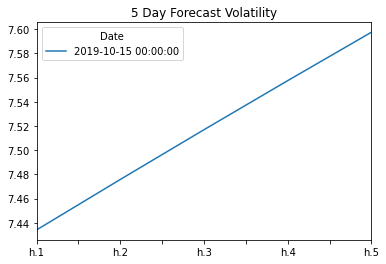

In [84]:
# Plot the final forecast

final.plot(title="5 Day Forecast Volatility")

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

In [ ]:
# Based on the pure return and price forecasts by ARMA and ARIMA models, it would seem reasonable to invest in Yen at this time. 

# However, the prediction confidence levels of both ARMA and ARIMA models are not satisfactory compared to our set treshold of p < 0.05, which renders these models not suiable for prediction of this dataset.

# Based on the GARCH model the volatility of Yen will increase over the next five days. Given the lack of predictive usefulness of ARMA and ARIMA models, the decision whether to invest in Yen at this time will depend mon our opinion whether the predicted volatility can achieve the set expected return at the acceptable potential loss as the downside risk of the same volatility. 

